This notebook adresseses a single machine scheduling problem. The objective studied is minimizing the sum of maximum lateness (tardiness) on a single machine with release times.

Each job is associated with:

- proccesing time
- release time
- due date

A job is tardy if the completion time of job j is later than the due date. All jobs need to be processed on the single machine and preemption is not allowed.

The scheduling problem can be represented by 1| $r_j$ |  Max $L_j$ . This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model. 

In [1]:
nbrOfJobs = 10

In [2]:
jobs = [*range(0, nbrOfJobs)] 

In [3]:
minProcessingTime=10
maxProcessingTime=40
import random
processingTimes = [random.randint(minProcessingTime, maxProcessingTime) for j in jobs]

In [4]:
minDueDate=50
maxDueDate=250
dueDates = random.sample(range(minDueDate, maxDueDate), len(jobs))

In [5]:
minReleaseTime=1
maxReleaseTime=50
releaseTimes = [random.randint(minReleaseTime, maxReleaseTime) for j in jobs]

In [6]:
import pandas as pd
JobsTable = pd.DataFrame(columns=['job', 'processing_time', 'release_time', 'due_date'])
for j in jobs:
    JobsTable=JobsTable.append({'job': j,'processing_time':processingTimes[j],'release_time':releaseTimes[j],'due_date':dueDates[j]}, ignore_index=True)
print(JobsTable)

  job processing_time release_time due_date
0   0              21           44      194
1   1              27           41      159
2   2              33           42      198
3   3              27           36      158
4   4              13           46      156
5   5              31           22      208
6   6              25           19      150
7   7              33           21       57
8   8              12            6      220
9   9              16           46      190


In [7]:
from docplex.cp.model import *
mdl = CpoModel(name='singleMachineSchedulingMinMaxLateness') 

In [8]:
# define production processing interval of each job at each machine
processing_itv_vars = [mdl.interval_var(size=processingTimes[j], name="interval_job{}".format(j)) for j in jobs] 
for j in jobs:
    print(processing_itv_vars[j])

interval_job0 = intervalVar(size=21)
interval_job1 = intervalVar(size=27)
interval_job2 = intervalVar(size=33)
interval_job3 = intervalVar(size=27)
interval_job4 = intervalVar(size=13)
interval_job5 = intervalVar(size=31)
interval_job6 = intervalVar(size=25)
interval_job7 = intervalVar(size=33)
interval_job8 = intervalVar(size=12)
interval_job9 = intervalVar(size=16)


In [9]:
# define maximum lateness variable
maxLateness_var = mdl.integer_var(name="maxLateness")

In [10]:
#define objective 
objective = maxLateness_var
mdl.add(mdl.minimize(objective)) 

In [11]:
#ensure that jobs start after release times
for j in jobs:
    mdl.add(mdl.start_of(processing_itv_vars[j])>=releaseTimes[j])

In [12]:
#define maximum lateness
for j in jobs:
    mdl.add(mdl.max([0,mdl.end_of(processing_itv_vars[j])-dueDates[j]])<=maxLateness_var)

In [13]:
#No overlap constraint
mdl.add(mdl.no_overlap([processing_itv_vars[j] for j in jobs])) 

In [14]:
msol= mdl.solve(log_output=True)

In [15]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 21, variables: integer: 1, interval: 10, sequence: 1
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.19 sec
-------------------------------------------------------------------------------
Objective values: (37,), bounds: (37,), gaps: (0,)
maxLateness=37
interval_job0: (start=133, end=154, size=21, length=21)
interval_job1: (start=154, end=181, size=27, length=27)
interval_job2: (start=181, end=214, size=33, length=33)
interval_job3: (start=106, end=133, size=27, length=27)
interval_job4: (start=77, end=90, size=13, length=13)
interval_job5: (start=214, end=245, size=31, length=31)
interval_job6: (start=19, end=44, size=25, length=25)
interval_job7: (start=44, end=77, size=33, length=33)
interval_job8: (start=6, end=18, size=12, length=12)
interval_job9: (start=90, end=106, size=16, len

In [16]:
for j in jobs:
    if((msol.get_var_solution(processing_itv_vars[j]).get_end()) > dueDates[j]):
       print("job {} lateness is {}".format(j,msol.get_var_solution(processing_itv_vars[j]).get_end()-dueDates[j]))

job 1 lateness is 22
job 2 lateness is 16
job 5 lateness is 37
job 7 lateness is 20


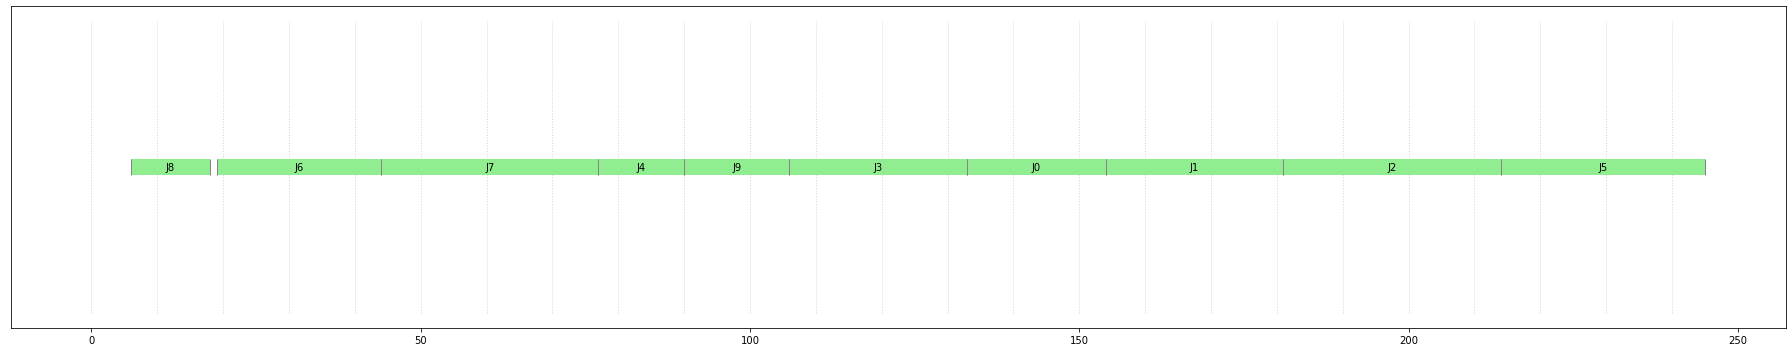

In [17]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
if msol and visu.is_visu_enabled():
    visu.timeline("Solution Schedule", 0, 100)
    for j in jobs:
        itv = msol.get_var_solution(processing_itv_vars[j])
        if itv.is_present():
            visu.interval(itv,'lightgreen','J' + str(j))
    visu.show()